# STA 141B Final Project

Group 2

Man Chuen Chau (919819081)




### Review the Coexistence with COVID-19 Policy in USA

### 1.	  Abstract

The COVID-19 Pandemic has been happening for two and a half years. This coronavirus disease has varied from Alpha to the latest Omicron variant. Unfortunately, this latest variant has the highest rate of infection though its death rate seems lower than the Delta variant (Katella, 2021). Nevertheless, the federal government of the United States has advocated to coexist with COVID-19 since the end of 2021. The goal of this coexistence with COVID-19 policy is to let people continue to live as usual and maintain economic growth. This COVID-19 policy has been implemented for almost one year which is long enough to reflect the effectiveness of this policy. However, the trend of death is the primary key to determine whether this public health policy is sucessful or not. If the death rate of the Omicron variant was as high as the Delta variant, the Coexistence with COVID-19 Policy was not workable  for sure because people was living in fear; the government had to execute a lockdown of city that led to lower GDP but higher unemployment rate. This project will analyze the COVID-19 data from Centers for Disease Control and Prevention (CDC), build up a statistical model for the death of COVID-19, analyze the recent economic data, and then review if the coexistence with COVID-19 policy is effective as expected.


### 2.  Introduction

COVID-19 is still spreading all over the world. According to the data reported from World Health Organization (World Health Organization. n.d., 2022), In November of 2022, the new cases of COVID-19 in the countries around the world are over 8,600,000 and the new deaths are around 31,000 respectively. Although a ton of people still get infected every single day, the death rate seems very low. The spread of COVID-19 can never stop. Lockdown and cross border travel restriction cannot continue forever. The federal government of the United States realized that all people needed to learn to live with COVID-19, so she advocated the coexistence with COVID-19 policy. The federal governemnt cherished the hope that this coexistence policy would help to recover people’s living and continue their economic growth. Nonetheless, this policy might create a ton of new inflection cases which might put a heavy burden on the medical system regardless of the spread of the virus and many people suffering from COVID-19. The federal government was facing the dilemma of implementing this policy or not.

The COVID-19 infected people would be classified as new cases. Some of the new cases will be classified as new deaths if they cannot make it through. Thus, there is certainly a relationship between new cases and new deaths. All new death cases indicate that all critical patients needed intensive and critical care medicine before death; it will consume much medical resources but this consumption will increase GDP in the short run. If a medical system crashes due to insufficient resources, all patients, including other non-COVID-19 infected patients, might die of no treatment, not die of the disease. In this situation, if the government orders a lockdown of city again, GDP will decrease due to reducing human assets and the lockdown will also push up the unemployment rate. Gross Domestic Product (GDP) and unemployment rate are the meters to measure economic growth. First of all, the coexistence with COVID-19 policy is really effective as long as the number of deaths must be at a lower level than what can ever collapse the medical system. Lockdown is unnecessary anymore. People should stop living in fear of inflection. The economy keeps going on the current growth path. That is why the trend of the death is so important to the coexistence policy. If the trend of deaths becomes upwardly sloping, it implies that coexistence with the COVID-19 policy endangers society.

The aim of this review report is to analyze the COVID-19 data from Centers for Disease Control and Prevention (CDC) and try to find out if the trend of the death is really going down, and then review the recent economic information to determine if the coexistence with COVID-19 policy is effective.


### 3.	Data and Methods

### 3.1 COVID-19 Data Model

All COVID-19 data is obtained from the CDC official website using web API provided by CDC. The data are in json format. Each json data contains only 100 records which form a data segment. CDC does not allow public to download all data at a time. CDC divides the whole dataset into many data seqments. Each data seqment has an offset number. Public is required to provide an offset number in the query string of the web API to inform CDC which data segment they would like to download. Thus, it is necessary to save the downloaded data with the responding offset number into a sqlite3 database. Due to the saved latest offset number, we just need to download the data segment(s) with the offset numbers which is/are larger than the saved latest offset number when CDC updates the dataset; we do not need to download all data again. It can save much network traffic and downloading time. 

The COVID-19 data table description:

    Column Name       Description                    Type
------------------------------------------------------------------------
    submission_date   Date of counts                 Date & Time
    state	          States                         Text
    tot_cases	      Total number of cases          Number
    conf_cases	      Total confirmed cases          Number
    prob_cases	      Total probable cases           Number
    new_case	      Number of new cases            Number
    pnew_case	      Number of new probable cases   Number
    tot_death	      Total number of death          Number
    prob_death	      Total probable death           Number
    new_death	      Number of new death            Number
    pnew_death	      Number of new probable death   Number
    
    


### 3.2 Methods

Describe how to setup a regression model, how to select the model, and how to test the model.

### 3.3	COVID-19 Data Analysis

In [4]:
# Libraries
import pandas as pd
import sqlite3 as sql
import requests as req
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter


In [5]:
# create a new table for COVID 19 data
conn = sql.connect("STA141B_Db.sqlite")

#drop_covid_table = "DROP TABLE COVID_19;"
#conn.execute(drop_covid_table)

create_covid_table = """CREATE TABLE IF NOT EXISTS COVID_19 (
                               submission_date Date NOT NULL,
                               state text NOT NULL,
                               tot_cases Integer,
                               conf_cases Integer,
                               prob_cases Integer,
                               new_case Integer,
                               pnew_case Integer,
                               tot_death Integer,
                               new_death Integer,
                               pnew_death Integer,
                               offset NOT NULL                            
                   );"""

conn.execute(create_covid_table)

conn.close()

In [6]:
# Obtain the data from CDC using CDC's Web API

conn = sql.connect("STA141B_Db.sqlite")

next_offset = 0

# get the last offset
last_offset = pd.read_sql_query("""
    SELECT MAX(offset) AS offset FROM COVID_19;
""", conn)

# set i = max offset
if last_offset.shape[0] > 0 and last_offset["offset"][0] is not None:
    next_offset = last_offset["offset"][0] + 1

while True:
    
    # initialize the offset value
    if next_offset == 0:
        offset=""
    else:
        offset=f"%20offset%20{next_offset}00"

    # Get data from CDC, the data is in json format
    url=f"https://data.cdc.gov/api/id/9mfq-cb36.json?$query=select%20*%2C%20%3Aid{offset}%20limit%20100"
    covid_data = pd.read_json(req.get(url).text)
        
    # if data found, insert the data into COVID_19 table
    if covid_data.shape[0] > 0:
        # Keep the useful columns for data analysis
        covid_data = covid_data[['submission_date', 'state', 'tot_cases','conf_cases','prob_cases','new_case','pnew_case','tot_death','new_death','pnew_death']].copy()
        # add the offset column
        covid_data['offset'] = next_offset        
        # insert into tbe COVID_19 table
        covid_data.to_sql('COVID_19', conn, if_exists='append', index=False)
        print('downloaded the offset = ', next_offset)
        #Increase offset
        next_offset+=1        
        time.sleep(0.1)
        print(next_offset)
    else:
        break

conn.close()


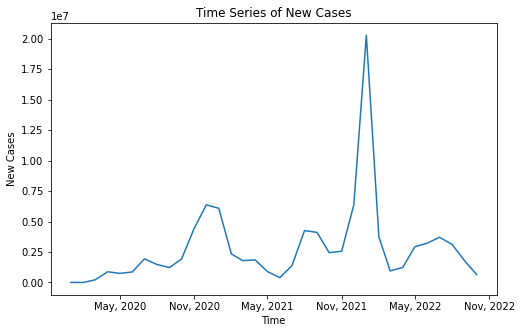

In [8]:
# 
conn = sql.connect("STA141B_Db.sqlite")

# extract new cases for time series
df_new_cases = pd.read_sql_query("""
    SELECT DATE(STRFTIME('%Y-%m-01', submission_date)) AS year_month, 
           sum(new_case) AS new_case
    FROM COVID_19 
    GROUP BY year_month;
""", conn)

conn.close()

df_new_cases['year_month'] = pd.to_datetime(df_new_cases['year_month'],  format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize=(8, 5))

half_year_locator = mdates.MonthLocator(interval=6)
month_year_formatter = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.title.set_text('Time Series of New Cases')
ax.set_xlabel('Time')
ax.set_ylabel('New Cases')
ax.plot(df_new_cases.year_month, df_new_cases.new_case);



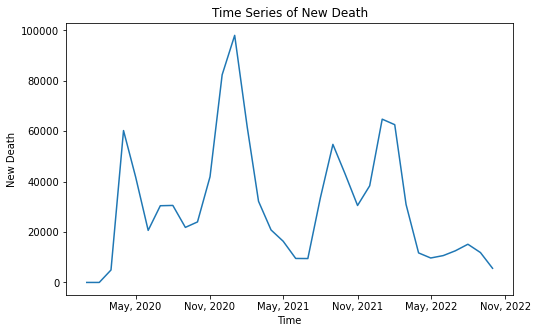

In [9]:
conn = sql.connect("STA141B_Db.sqlite")

# extract new death for time series
df_new_cases = pd.read_sql_query("""
    SELECT DATE(STRFTIME('%Y-%m-01', submission_date)) AS year_month, 
           sum(new_death) AS new_death
    FROM COVID_19 
    GROUP BY year_month;
""", conn)

conn.close()

df_new_cases['year_month'] = pd.to_datetime(df_new_cases['year_month'],  format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize=(8, 5))

half_year_locator = mdates.MonthLocator(interval=6)
month_year_formatter = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.title.set_text('Time Series of New Death')
ax.set_xlabel('Time')
ax.set_ylabel('New Death')
ax.plot(df_new_cases.year_month, df_new_cases.new_death);


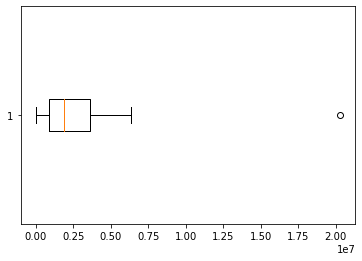

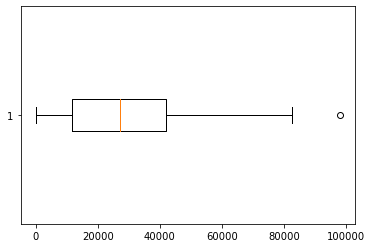

In [10]:
conn = sql.connect("STA141B_Db.sqlite")

# extract new cases for box plot
df_boxplot_data = pd.read_sql_query("""
    SELECT DATE(STRFTIME('%Y-%m-01', submission_date)) AS year_month, 
           sum(new_case) AS new_case,
           sum(new_death) AS new_death
    FROM COVID_19 
    GROUP BY year_month;
""", conn)

conn.close()

new_case = df_boxplot_data['new_case']
new_death = df_boxplot_data['new_death']

fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
ax1.boxplot(new_case, vert=0)
ax2.boxplot(new_death, vert=0)
plt.show()


array([[<AxesSubplot:xlabel='new_case', ylabel='new_case'>,
        <AxesSubplot:xlabel='pnew_case', ylabel='new_case'>,
        <AxesSubplot:xlabel='new_death', ylabel='new_case'>,
        <AxesSubplot:xlabel='pnew_death', ylabel='new_case'>],
       [<AxesSubplot:xlabel='new_case', ylabel='pnew_case'>,
        <AxesSubplot:xlabel='pnew_case', ylabel='pnew_case'>,
        <AxesSubplot:xlabel='new_death', ylabel='pnew_case'>,
        <AxesSubplot:xlabel='pnew_death', ylabel='pnew_case'>],
       [<AxesSubplot:xlabel='new_case', ylabel='new_death'>,
        <AxesSubplot:xlabel='pnew_case', ylabel='new_death'>,
        <AxesSubplot:xlabel='new_death', ylabel='new_death'>,
        <AxesSubplot:xlabel='pnew_death', ylabel='new_death'>],
       [<AxesSubplot:xlabel='new_case', ylabel='pnew_death'>,
        <AxesSubplot:xlabel='pnew_case', ylabel='pnew_death'>,
        <AxesSubplot:xlabel='new_death', ylabel='pnew_death'>,
        <AxesSubplot:xlabel='pnew_death', ylabel='pnew_death'>]],
   

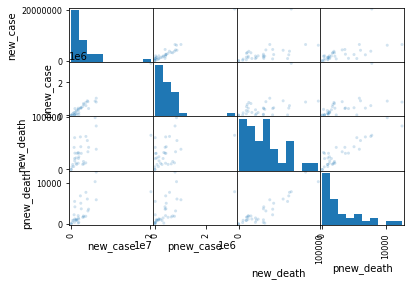

In [11]:
import statsmodels.api as sm 

conn = sql.connect("STA141B_Db.sqlite")

# extract new cases for box plot
df_boxplot_data = pd.read_sql_query("""
    SELECT sum(new_case) AS new_case,
           sum(pnew_case) AS pnew_case,
           sum(new_death) AS new_death,
           sum(pnew_death) AS pnew_death
    FROM COVID_19 
    GROUP BY DATE(STRFTIME('%Y-%m-01', submission_date));
""", conn)

conn.close()

pd.plotting.scatter_matrix(df_boxplot_data, alpha=0.2)


downloaded the offset =  601


### 3.3.1 Validation of data

Missing values, outliers, data integrity and data types, etc.

### 3.3.2	Descriptive COVID-19 Data

Perform descriptive analysis, means, variances, max, min, range etc.

### 3.3.3	Plots of the COVID-19 Data

Produce some plots

### 3.4	Inferential Analysis

- Obtain the scatter plot matrix for the data set.
- Use BIC to determine the number of the predictors of the model.
- test assumption, model selection, test the model,
- Conclude the findings (show that the trend of the death rate is slopping downward)


### 4.	Economic Data Analysis

- Use web scraping to obtain economic data from various websites and visualize the data, some sample tables and plots are given below.

- Show that the economies of some countries which is adopting coexistence with COVID-19 policy keep growing up (i.e. improve GDPs, and reduce unemployment rates).


### 4.1.	Impact on the international trade during the restriction of cross-border movement and lockdown

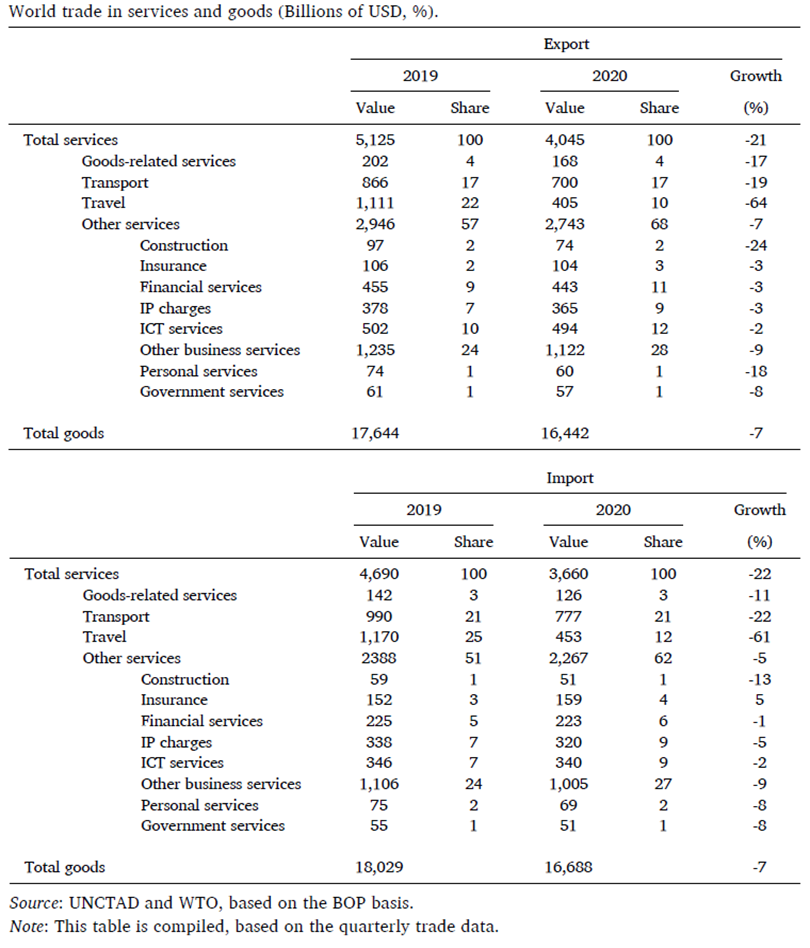

### 4.2.	The economic activities and the world GDP during 2021

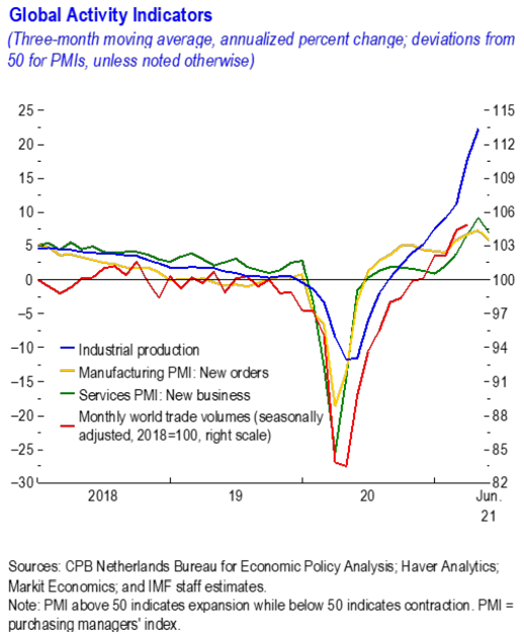

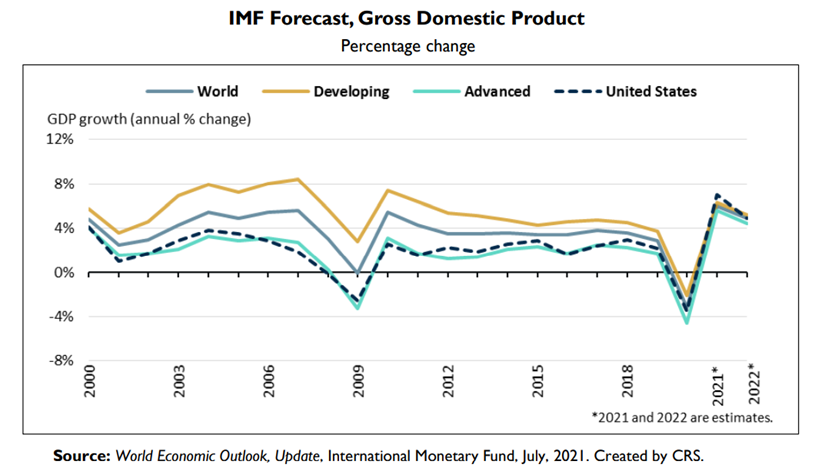


### 4.3.	The global economy after the beginning of 2022

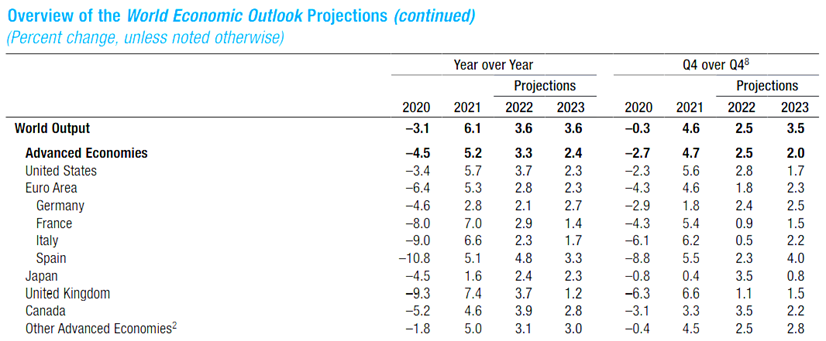

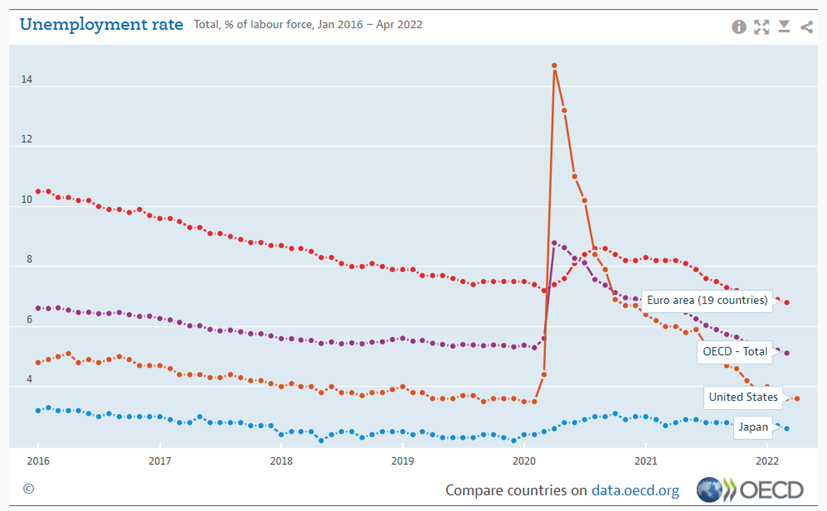


### 5.	Interpretation

### 6.	Conclusion

### 7.  Work Cited

Katella, K. (2021, December 20). Omicron, Delta, Alpha, and More: What To Know About the Coronavirus Variants. Yale Medicine. https://www.yalemedicine.org/news/covid-19-variants-of-concern-omicron

World Health Organization. (n.d.). World Health Organization. Retrieved June 30, 2022, from https://covid19.who.int/data

